In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA
import networkx as nx

import sys
sys.path.insert(1, "../")

import SpringRank_tools as sr
import tools as tl

from time import time
from copy import deepcopy as copy

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Update Process

In [2]:
def Laplacian(G):
    k_in = np.sum(G, 0)
    k_out = np.sum(G, 1)
    return np.diag(k_in + k_out) - (A + A.T)

def operator_P(x, P):
    if len(x.shape) == 2:
        x_P = x[P][:, P]
    elif len(x.shape) == 1:
        x_P = x[P]
    else:
        raise ValueError("invalid shape")
    return x_P

def get_neighbors(G, P):
    idx_0 = set(np.nonzero(G[P])[0])
    idx_1 = set(np.nonzero(G[:,P])[0])
    N = idx_0.union(idx_1) - set(P)
    return list(N)

In [18]:
def update_ranks(A, s_0, P, num_iter=100, tol=1e-7):
    L = Laplacian(A)
    s_est = copy(s_0)
    d_hat = np.sum(A, 1) - np.sum(A, 0)
    RHS = d_hat - np.matmul(L, s_0)

    L_p = operator_P(L, P)
    RHS_p = operator_P(RHS, P)
    delta_p = LA.solve(L_p, RHS_p)
    s_est[P] = s_est[P] + delta_p
    
    N = get_neighbors(A, P)
    for i in range(num_iter):
        L_n = operator_P(L, N)
        RHS_n = operator_P(d_hat - np.matmul(L, s_est), N)
        delta_n = LA.solve(L_n, RHS_n)
        s_est[N] = s_est[N] + delta_n
        N = get_neighbors(A, N)
    
    return s_est

def kth_order_update(A, s_0, N0, order, return_compute_times=False):
    L = Laplacian(A)
    s_est = copy(s_0)
    d_hat = np.sum(A, 1) - np.sum(A, 0)
    RHS = d_hat - np.matmul(L, s_0)
    
    start_time = time()
    N = set(N0)
    for k in range(order):
        N = N.union(get_neighbors(A, list(N)))
    N = list(N)
    end_time = time()
    neighbor_time = end_time - start_time
    
#     start_time = time()
    L_n = operator_P(L, N)
    RHS_n = operator_P(RHS, N)
    
    start_time = time()
#     try:
#         delta_n = spLA.spsolve(L_n, RHS_n)
#     except:
    result = spLA.lsqr(L_n, RHS_n)
    delta_n = result[0]
    end_time = time()
    solve_time = end_time - start_time
    
    s_est[N] = s_est[N] + delta_n
    
    if return_compute_times:
        return s_est, N, (neighbor_time, solve_time)
    else:
        return s_est, N

## Test on large network

In [9]:
beta = 0.5
p_ij = 1 / (1 + np.exp(-2*beta))
alpha = 1
N = 500
K = 10

A_0 = sr.SpringRank_planted_network(N, beta, alpha, K)
s_0 = sr.SpringRank(A_0)
s_0 = tl.adjust_ranks(s_0, A_0, p_ij=p_ij)

In [10]:
node_x = 35
node_y = 70
A_xy = 1
A_yx = 0

A = copy(A_0)
A[node_x, node_y] += A_xy
A[node_y, node_x] += A_yx
P = [node_x, node_y]

In [11]:
s = sr.SpringRank(A)
s = tl.adjust_ranks(s, A, p_ij=p_ij)

print("Difference:")
print(LA.norm(s - s_0, ord=2))

Difference:
0.3242909988060171


### kth order update

In [31]:
s_all = []
fraction_nodes = []
neighbors = []
errors = []
elapsed_times = []
neighbor_times = []
solve_times = []

max_order = 5
orders = list(range(max_order+1))

num_reps = 1

baseline_time = 0
for i in range(num_reps):
    start_time = time()
    _ = sr.SpringRank(A)
    end_time = time()
    baseline_time += end_time - start_time
baseline_time /= num_reps

for k in orders:
    
    elapsed_time_k = 0
    neighbor_time_k = 0
    solve_time_k = 0
    for i in range(num_reps):
        start_time = time()
        s_k, N_k, times = kth_order_update(A, s_0, P, order=k, return_compute_times=True)
        end_time = time()
        elapsed_time_k += end_time - start_time
        neighbor_time_k += times[0]
        solve_time_k += times[1]
    elapsed_times.append(elapsed_time_k / num_reps)
    neighbor_times.append(neighbor_time_k / num_reps)
    solve_times.append(solve_time_k / num_reps)
    
    fraction_k = len(N_k) / N
    fraction_nodes.append(fraction_k)
    
    s_k = tl.adjust_ranks(s_k, A, p_ij=p_ij)
    s_all.append(s_k)
    neighbors.append(N_k)
    
    error_k = LA.norm(s_k - s, ord=2)
    errors.append(error_k)

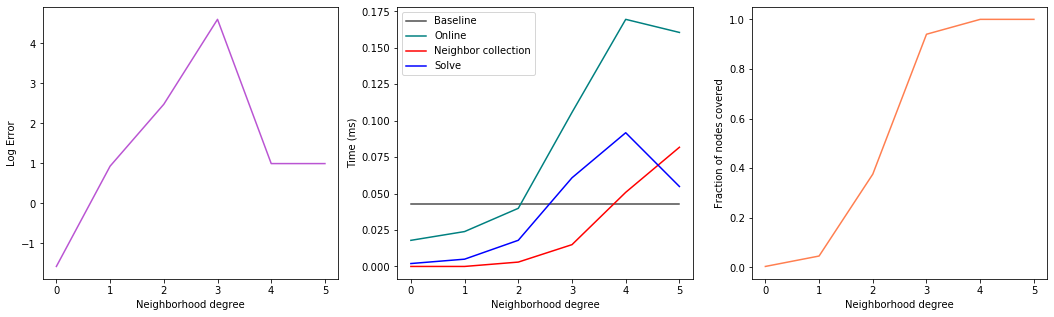

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax[i].set_xlabel("Neighborhood degree")
    ax[i].set_xticks(orders)

ax[0].plot(orders, np.log(errors), color="mediumorchid")
ax[0].set_ylabel("Log Error")


ax[1].plot(orders, [baseline_time]*len(orders), color='black', alpha=0.7, label="Baseline")
ax[1].plot(orders, elapsed_times, color="teal", label="Online")
ax[1].plot(orders, neighbor_times, color="red", label="Neighbor collection")
ax[1].plot(orders, solve_times, color="blue", label="Solve")
ax[1].set_ylabel("Time (ms)")
ax[1].legend()


ax[2].plot(orders, fraction_nodes, color="coral")
ax[2].set_ylabel("Fraction of nodes covered")

plt.show()

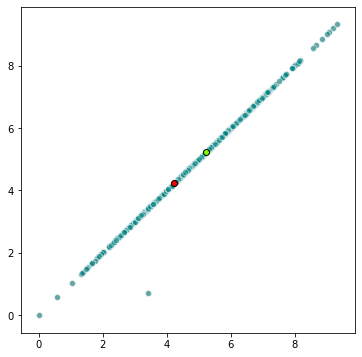

In [48]:
plt.figure(figsize=(6, 6))

k = 5

plt.scatter(s, s_all[k], color="grey", edgecolor="white", alpha=0.4)

plt.scatter(s[neighbors[k]], s_all[k][neighbors[k]], color="teal", edgecolor="white", alpha=0.5)

plt.scatter(s[node_x], s_all[k][node_x], color="red", edgecolor="black")
plt.scatter(s[node_y], s_all[k][node_y], color="lawngreen", edgecolor="black")


plt.show()

In [21]:
L = Laplacian(A)
d_hat = np.sum(A, 1) - np.sum(A, 0)
RHS = d_hat - np.matmul(L, s_0)


start = time()
result = spLA.bicgstab(L, RHS)
delta = result[0]
end = time()
elapsed = end - start

x = s_0 + delta
x = tl.adjust_ranks(x, A, p_ij=p_ij, interval=(-10, 10))

L2error = LA.norm(x - s, ord=2)
print(np.log(L2error))

print(elapsed, baseline_time)

0.9957596078307922
0.013961553573608398 0.042887210845947266
